# Twitter Sentiment Analysis

# 1 - Packages

Let's first import all the packages that I'll be using during this project.

* **numpy** is the main package for scientific computing with Python.
* **pandas** is a library for data manipulation and analysis.
* **train_test_split** is used to split our training data into training, dev datasets.
* **wordcloud, matplotlib** to draw word cloud plots.
* **LogisticRegression, BernoulliNB, MultinomialNB** are used in this notebook to determine which one of these works best for this dataset.
* **cross_val_score** evaluates a score by cross validation.

In [184]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# 2 - Dataset

* We imported the train, test data which I found on internet.
* We then splitted the train data into two datasets, one contained features and other contained the target variables.

In [185]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
X_train = np.array(train['tweet']).reshape(int(train.size)//3, 1)
Y_train = np.array(train['label'])#.reshape(int(train.size)//3, 1)
X_test = np.array(test['tweet']).reshape(int(test.size)//2, 1)

print('There are {} tweets in training set.'.format(X_train.shape[0]))
print('There are {} tweets in test set.'.format(X_test.shape[0]))

There are 31962 tweets in training set.
There are 17197 tweets in test set.


# 3 - Data Pre-processing

* **remove_pattern** function is used to remove the twitter handles from tweets.
* I merged train, test datasets bcz we are going to perform a lot of tasks on our datasets and so this merge makes those tasks easier.
* I then replaced all the useless symbols which aren't going to help in the training process.

In [186]:
def remove_pattern(text, pattern):
    p = re.findall(pattern, text)
    for i in p:
        text = re.sub(i, '', text)
    return text

tweets = np.concatenate((X_train, X_test))
tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
tweets = [tweets[i][0].replace("[^a-zA-Z#]", " ") for i in range(tweets.shape[0])]

## Stemming -
Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.

* Here we removed all the suffixes from our dataset which made our dataset lot tidier.

In [187]:
tweets_tokenized = [re.sub("[^\w]", " ",  tweets[i]).split() for i in range(len(tweets))]

stemmer = PorterStemmer()
tweets_stemmed = []

for i in range(len(tweets_tokenized)):
    tweets_stemmed.append([])
    for word in tweets_tokenized[i]:
        tweets_stemmed[i].append(stemmer.stem(word))

for i in range(len(tweets_tokenized)):
    tweets[i] = ' '.join(tweets_stemmed[i])

print(tweets[0:5])

['when a father is dysfunct and is so selfish he drag hi kid into hi dysfunct run', 'thank for lyft credit i can t use caus they don t offer wheelchair van in pdx disapoint getthank', 'bihday your majesti', 'model i love u take with u all the time in urð ð ð ð ð ð ð ð', 'factsguid societi now motiv']


## Bag of words -
Bag-of-Words is a method to represent text into numerical features. Consider a corpus (a collection of texts) called C of D documents {d1,d2…..dD} and N unique tokens extracted out of the corpus C. The N tokens (words) will form a list, and the size of the bag-of-words matrix M will be given by D X N. Each row in the matrix M contains the frequency of tokens in document D(i).

* We then splitted the features, targets into training, dev sets with 1/10 ratio.

In [195]:
m = len(X_train)
X_train = tweets[:m]
X_test = tweets[m:]

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.fit_transform(X_test)

X_Train, X_dev, Y_Train, Y_dev = train_test_split(X_train_bow, Y_train, test_size = 0.1,random_state = 42)

# 4 - Data Visualization

## Word Cloud - 
Word Cloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance. Significant textual data points can be highlighted using a word cloud. Word clouds are widely used for analyzing data from social network websites.

For generating word cloud in Python, modules needed are – matplotlib, pandas and wordcloud.

### Normal words - 
These words are those which frequently appeared in tweets which aren't racist/sexist and didn't cause negative emotions.

In our case words like -  love, happi, thank, weekend appeared most frequently in positive tweets.

### Negative words -
These words are those which frequently appeared in tweets which are racist/sexist and caused a lot of negative emotions.

In our case words like - white, black, woman, trump appeared most frequently in negative tweets.

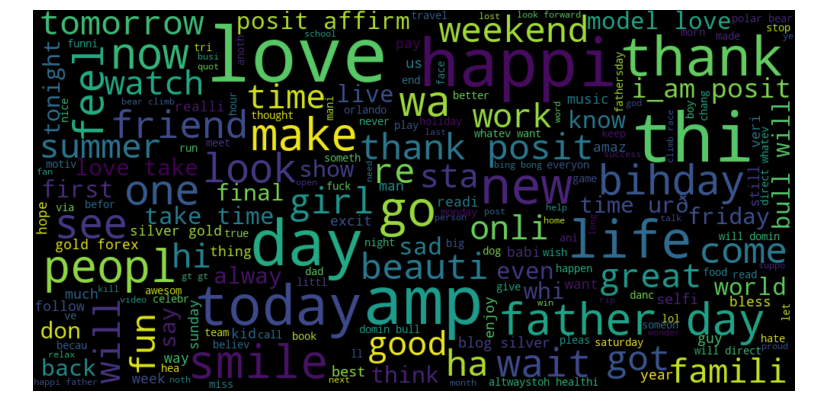

In [189]:
normal_words = ''
for i in range(len(X_train)):
    if Y_train[i] == 0:
        normal_words = normal_words + ' ' + ''.join([text for text in X_train[i]])
wordcloud = WordCloud(width=1000, height=500, random_state=42, max_font_size=100).generate(normal_words)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

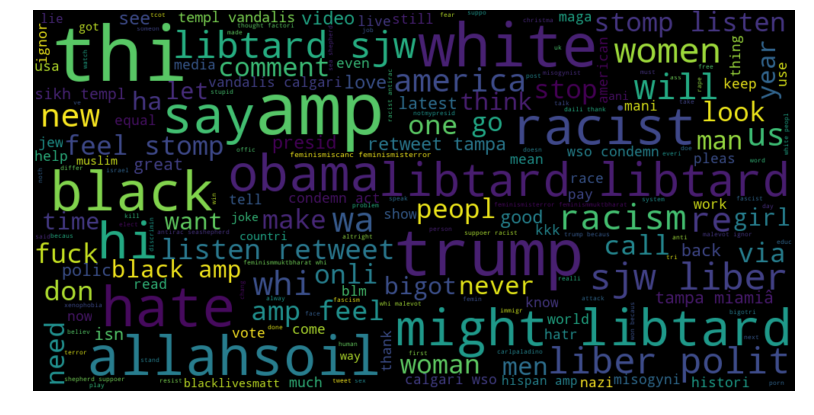

In [190]:
negative_words = ''
for i in range(len(X_train)):
    if Y_train[i] == 1:
        negative_words = negative_words + ' ' + ''.join([text for text in X_train[i]])
wordcloud = WordCloud(width=1000, height=500, random_state=42, max_font_size=100).generate(negative_words)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# 5 - Model Selection

In this notebooks I used 3 classifiers - 

* ## [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* ## [BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html)
* ## [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [194]:
lr = LogisticRegression()
bnb = BernoulliNB()
mnb = MultinomialNB()

models = {
    'logitic regression': lr,
    'bernoulliNB': bnb,
    'multinomialNB': mnb,
}

for model in models.keys():
    scores = cross_val_score(models[model], X_Train, Y_Train, scoring="f1", cv=10)
    print("===", model, "===")
    print("scores = ", scores)
    print("mean = ", scores.mean())
    print("variance = ", scores.var())
    models[model].fit(X_Train, Y_Train)
    print("score on the training set (accuracy) = ", accuracy_score(models[model].predict(X_Train), Y_Train) * 100)
    print("score on the dev set (accuracy) = ", accuracy_score(models[model].predict(X_dev), Y_dev)* 100)
    print("")

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


=== logitic regression ===
scores =  [0.53164557 0.48701299 0.50666667 0.50657895 0.52996845 0.5704918
 0.49032258 0.48684211 0.53114754 0.48442907]
mean =  0.5125105720841561
variance =  0.0007039295959450056
score on the training set (accuracy) =  95.36937250130367
score on the dev set (accuracy) =  94.87019080387864

=== bernoulliNB ===
scores =  [0.57568238 0.49122807 0.52266667 0.53333333 0.53921569 0.58701299
 0.53170732 0.50385604 0.52820513 0.49468085]
mean =  0.5307588463070164
variance =  0.0008921767916384644
score on the training set (accuracy) =  94.02398748479054
score on the dev set (accuracy) =  93.68157647794808

=== multinomialNB ===
scores =  [0.57831325 0.47901235 0.52173913 0.53470437 0.5450237  0.5764411
 0.54373522 0.51371571 0.525      0.48205128]
mean =  0.5299736116105911
variance =  0.0010184678922950446
score on the training set (accuracy) =  93.82930644880932
score on the dev set (accuracy) =  93.46262120738193



# 6 - Conclusion

* Logistic Regression worked best for our dataset with training accuracy 95.36 and testing accuracy 94.87.
* In this project I learned a lot of cool stuff like how to pre-process text data, visualization techniques like word cloud.